<a href="https://colab.research.google.com/github/Madhumitha0306/Data_Science_Project/blob/main/Level_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PREDICTIVE MODELING**

In [1]:
# upload the dataset
from google.colab import files
uploaded = files.upload()

Saving Dataset .csv to Dataset .csv


In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Modeling / preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Utilities
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


In [6]:
# basic info about dataset
df = pd.read_csv('Dataset .csv')
print("Rows, Columns:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())

Rows, Columns: (9551, 21)

Column Names:
 ['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address', 'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Price range', 'Aggregate rating', 'Rating color', 'Rating text', 'Votes']

Missing Values:
 Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64


In [7]:
# Target column
target_col = 'Aggregate rating'
print("\nTarget column:", target_col)


Target column: Aggregate rating


In [8]:
# Summary statistics
print("\nSummary Statistics:")
print(df[target_col].describe())


Summary Statistics:
count    9551.000000
mean        2.666370
std         1.516378
min         0.000000
25%         2.500000
50%         3.200000
75%         3.700000
max         4.900000
Name: Aggregate rating, dtype: float64


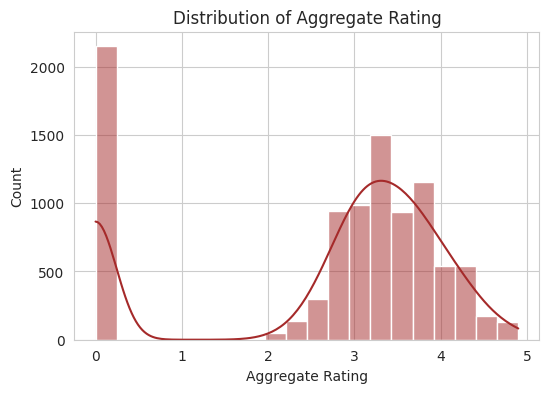

In [70]:
# Plot distribution of target column
plt.figure(figsize=(6,4))
sns.histplot(df[target_col], kde=True, bins=20, color='brown')
plt.title("Distribution of Aggregate Rating")
plt.xlabel("Aggregate Rating")
plt.ylabel("Count")
plt.show()


In [11]:
# Check top values of key categorical columns
for col in ['City', 'Cuisines', 'Rating text']:
    if col in df.columns:
        print(f"\nTop values for '{col}':")
        print(df[col].value_counts().head())


Top values for 'City':
City
New Delhi    5473
Gurgaon      1118
Noida        1080
Faridabad     251
Ghaziabad      25
Name: count, dtype: int64

Top values for 'Cuisines':
Cuisines
North Indian             936
North Indian, Chinese    511
Chinese                  354
Fast Food                354
North Indian, Mughlai    334
Name: count, dtype: int64

Top values for 'Rating text':
Rating text
Average      3737
Not rated    2148
Good         2100
Very Good    1079
Excellent     301
Name: count, dtype: int64


In [12]:
# Select features automatically:
# - Numeric features (except target)
# - Top categorical features with limited unique values (<= 30 unique)
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

cat_candidates = df.select_dtypes(include=['object','category']).columns.tolist()
# keep categorical columns with <=30 unique values (safe for one-hot)
cat_cols = [c for c in cat_candidates if df[c].nunique() <= 30]

print("Numeric columns used:", numeric_cols)
print("Categorical columns used:", cat_cols)

# Keep these columns + target
use_cols = numeric_cols + cat_cols + [target_col]
data = df[use_cols].copy()
data.shape


Numeric columns used: ['Restaurant ID', 'Country Code', 'Longitude', 'Latitude', 'Average Cost for two', 'Price range', 'Votes']
Categorical columns used: ['Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Rating color', 'Rating text']


(9551, 15)

In [13]:
# Drop rows where target is missing
data = data.dropna(subset=[target_col]).reset_index(drop=True)

X = data.drop(columns=[target_col])
y = data[target_col].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (7640, 14) Test shape: (1911, 14)


In [16]:
# Numeric pipeline: impute (mean) + scale (for linear model)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute (most frequent) + one-hot encode (drop='first' to avoid multicollinearity)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor_for_linear = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ], remainder='drop'
)

# For tree-based models we usually don't need scaling; simple imputer + one-hot is fine
numeric_transformer_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])
categorical_transformer_tree = categorical_transformer  # same as above

preprocessor_for_tree = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_tree, numeric_cols),
        ('cat', categorical_transformer_tree, cat_cols)
    ], remainder='drop'
)


In [20]:
# evaluate model
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return {'model': name, 'rmse': rmse, 'mae': mae, 'r2': r2}


In [21]:
# linear regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_for_linear),
    ('regressor', LinearRegression())
])

# Train
lr_pipeline.fit(X_train, y_train)

# Evaluate
lr_results = evaluate_model("LinearRegression", lr_pipeline, X_test, y_test)


LinearRegression -> RMSE: 0.1763 | MAE: 0.1293 | R2: 0.9863


In [22]:
# decision tree regressor
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_for_tree),
    ('regressor', DecisionTreeRegressor(random_state=42, max_depth=8))
])

dt_pipeline.fit(X_train, y_train)
dt_results = evaluate_model("DecisionTree", dt_pipeline, X_test, y_test)


DecisionTree -> RMSE: 0.1725 | MAE: 0.1177 | R2: 0.9869


In [23]:
# random forest regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_for_tree),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100, max_depth=12, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
rf_results = evaluate_model("RandomForest", rf_pipeline, X_test, y_test)


RandomForest -> RMSE: 0.1653 | MAE: 0.1127 | R2: 0.9880


In [24]:
# Compare results in a DataFrame
results = pd.DataFrame([lr_results, dt_results, rf_results])
results = results.sort_values(by='rmse')
results.reset_index(drop=True, inplace=True)
results

,model,rmse,mae,r2
0,RandomForest,0.165329,0.112654,0.987991
1,DecisionTree,0.172543,0.117661,0.986920
2,LinearRegression,0.176276,0.129319,0.986348


In [25]:
# Get feature names after preprocessing
# Note: OneHotEncoder creates many columns. This reconstructs names.
ohe = None
cat_feature_names = []
if len(cat_cols) > 0:
    # access the onehot encoder from the pipeline
    ct = rf_pipeline.named_steps['preprocessor']
    # numeric names
    num_names = numeric_cols
    # get onehot encoder
    ohe = ct.named_transformers_['cat'].named_steps['onehot']
    ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names = num_names + ohe_names
else:
    feature_names = numeric_cols

# Extract feature importances from the RandomForest
importances = rf_pipeline.named_steps['regressor'].feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)
feat_imp


,feature,importance
35,Rating text_Not rated,0.342684
6,Votes,0.335865
30,Rating color_White,0.225452
32,Rating text_Average,0.026573
28,Rating color_Orange,0.025316
29,Rating color_Red,0.011559
36,Rating text_Poor,0.010785
31,Rating color_Yellow,0.006948
34,Rating text_Good,0.006161
0,Restaurant ID,0.002167


In [26]:
# 5-fold CV RMSE for RandomForest
from sklearn.model_selection import cross_val_score
rf_cv = Pipeline(steps=[
    ('preprocessor', preprocessor_for_tree),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1))
])
scores = cross_val_score(rf_cv, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rmse_scores = np.sqrt(-scores)
print("RF CV RMSE mean:", rmse_scores.mean(), "std:", rmse_scores.std())


RF CV RMSE mean: 0.1702930479967139 std: 0.003454453952644267


In [28]:
import joblib
# pick the best from results (here we assume RandomForest is best)
best_pipeline = rf_pipeline
joblib.dump(best_pipeline, "best_restaurant_rating_model.joblib")
print("Saved model to best_restaurant_rating_model.joblib")



Saved model to best_restaurant_rating_model.joblib


**CUSTOMER PREFERENCE ANALYSIS**

In [29]:
# Check for missing values in important columns
print(df[['Cuisines', 'Aggregate rating', 'Votes']].isnull().sum())

# Drop rows where cuisine or rating is missing
df = df.dropna(subset=['Cuisines', 'Aggregate rating'])
print("Data after dropping missing values:", df.shape)


Cuisines            9
Aggregate rating    0
Votes               0
dtype: int64
Data after dropping missing values: (9542, 21)


In [31]:
# Since many restaurants list multiple cuisines (comma separated),
# take the first cuisine as the main one for simplicity
df['Main_Cuisine'] = df['Cuisines'].apply(lambda x: x.split(',')[0].strip())

# Compute average rating per cuisine
avg_rating = df.groupby('Main_Cuisine')['Aggregate rating'].mean().sort_values(ascending=False)

# Show top 10 cuisines by average rating
print("Top 10 cuisines with highest average ratings:")
print(avg_rating.head(10))



Top 10 cuisines with highest average ratings:
Main_Cuisine
Sunda            4.900000
Scottish         4.700000
Cajun            4.700000
Taiwanese        4.650000
Filipino         4.616667
Persian          4.600000
Ramen            4.600000
World Cuisine    4.500000
Argentine        4.500000
Hawaiian         4.480000
Name: Aggregate rating, dtype: float64


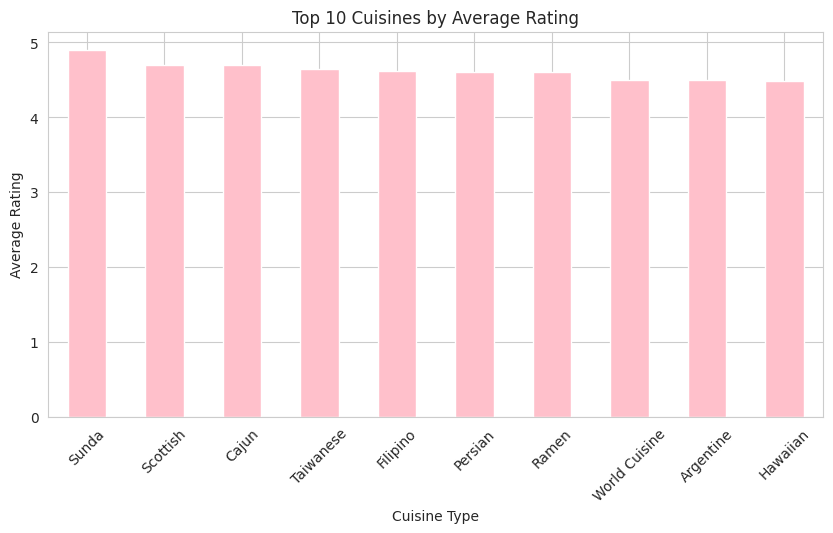

In [41]:
# Plot average rating by cuisine (top 10)
plt.figure(figsize=(10,5))
avg_rating.head(10).plot(kind='bar', color='pink')
plt.title("Top 10 Cuisines by Average Rating")
plt.ylabel("Average Rating")
plt.xlabel("Cuisine Type")
plt.xticks(rotation=45)
plt.show()

In [43]:
# most popular cuisine
# Sum votes for each cuisine
popular_cuisines = df.groupby('Main_Cuisine')['Votes'].sum().sort_values(ascending=False)

# Show top 10 popular cuisines
print("Top 10 most popular cuisines (by votes):")
print(popular_cuisines.head(10))



Top 10 most popular cuisines (by votes):
Main_Cuisine
North Indian    356684
Cafe            116576
American        105447
Italian          95153
Continental      94569
Chinese          84918
European         45842
Fast Food        42617
Bakery           42008
Pizza            36415
Name: Votes, dtype: int64


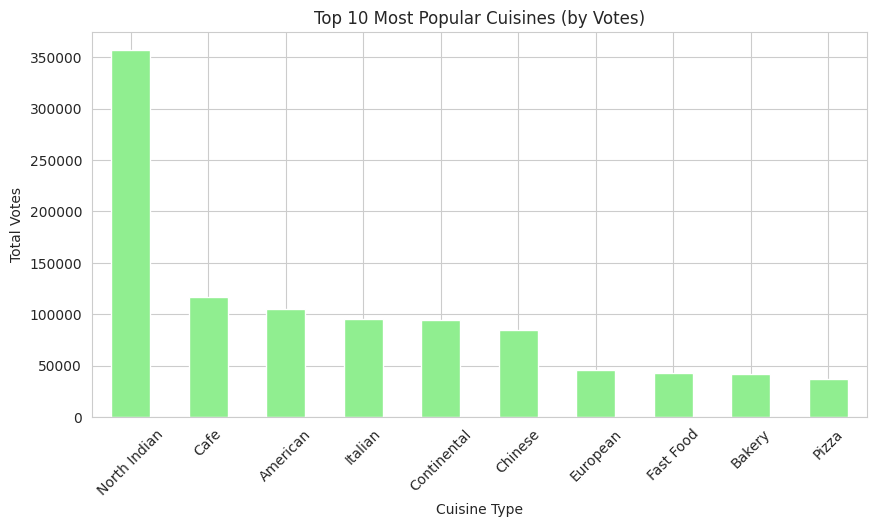

In [44]:
# Plot
plt.figure(figsize=(10,5))
popular_cuisines.head(10).plot(kind='bar', color='lightgreen')
plt.title("Top 10 Most Popular Cuisines (by Votes)")
plt.ylabel("Total Votes")
plt.xlabel("Cuisine Type")
plt.xticks(rotation=45)
plt.show()

In [45]:
# Merge both popularity and rating for combined view
cuisine_stats = pd.DataFrame({
    'Average_Rating': avg_rating,
    'Total_Votes': df.groupby('Main_Cuisine')['Votes'].sum()
}).sort_values(by='Average_Rating', ascending=False)

# Display top cuisines with both high rating and popularity
print("Cuisines ranked by high rating and total votes:")
print(cuisine_stats.head(10))

Cuisines ranked by high rating and total votes:
               Average_Rating  Total_Votes
Main_Cuisine                              
Sunda                4.900000         5514
Scottish             4.700000          163
Cajun                4.700000         1412
Taiwanese            4.650000          384
Filipino             4.616667         2727
Persian              4.600000          177
Ramen                4.600000          418
World Cuisine        4.500000         1244
Argentine            4.500000          602
Hawaiian             4.480000         5749


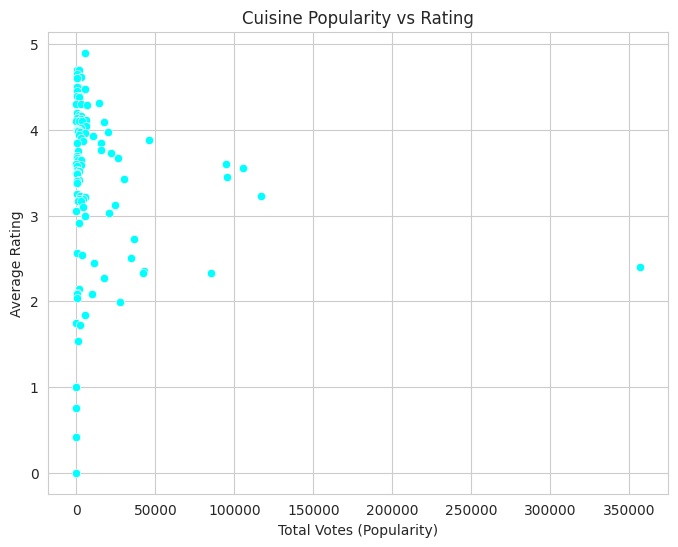

In [47]:
# Visualization – top cuisines by both metrics
plt.figure(figsize=(8,6))
sns.scatterplot(data=cuisine_stats, x='Total_Votes', y='Average_Rating',color='cyan')
plt.title("Cuisine Popularity vs Rating")
plt.xlabel("Total Votes (Popularity)")
plt.ylabel("Average Rating")
plt.show()

In [49]:
print("Insights Summary:")
print("----------------------")
print("1️⃣ Cuisines with higher average ratings are likely seen as high-quality or premium.")
print("2️⃣ Popular cuisines (high votes) indicate customer favorites and engagement.")
print("3️⃣ Some cuisines may have many votes but lower ratings — showing high demand but inconsistent satisfaction.")
print("4️⃣ Ideal recommendation: focus on cuisines with both high votes and high average ratings.")


Insights Summary:
----------------------
1️⃣ Cuisines with higher average ratings are likely seen as high-quality or premium.
2️⃣ Popular cuisines (high votes) indicate customer favorites and engagement.
3️⃣ Some cuisines may have many votes but lower ratings — showing high demand but inconsistent satisfaction.
4️⃣ Ideal recommendation: focus on cuisines with both high votes and high average ratings.


**DATA VISUALIZATION**

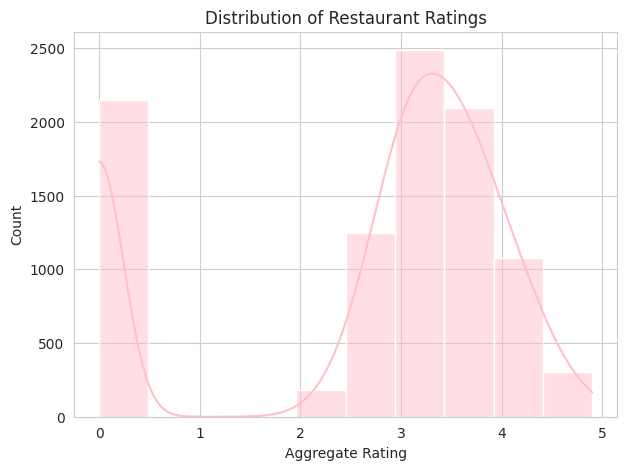

In [53]:
# Histogram
plt.figure(figsize=(7,5))
sns.histplot(df['Aggregate rating'], bins=10, kde=True, color='pink')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Aggregate Rating')
plt.ylabel('Count')
plt.show()

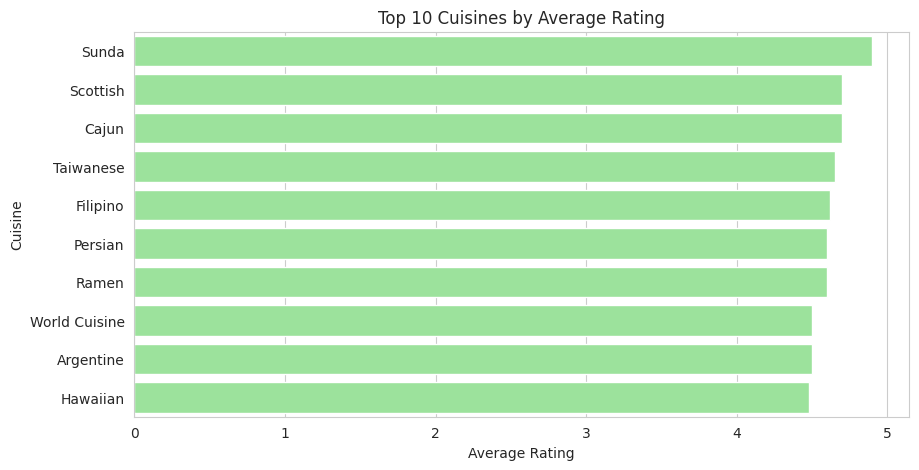

In [65]:
# Bar Plot: Average Rating by Cuisine (corrected)
plt.figure(figsize=(10,5))
sns.barplot(x=avg_rating_cuisine.values, y=avg_rating_cuisine.index, color='lightgreen')
plt.title('Top 10 Cuisines by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Cuisine')
plt.show()

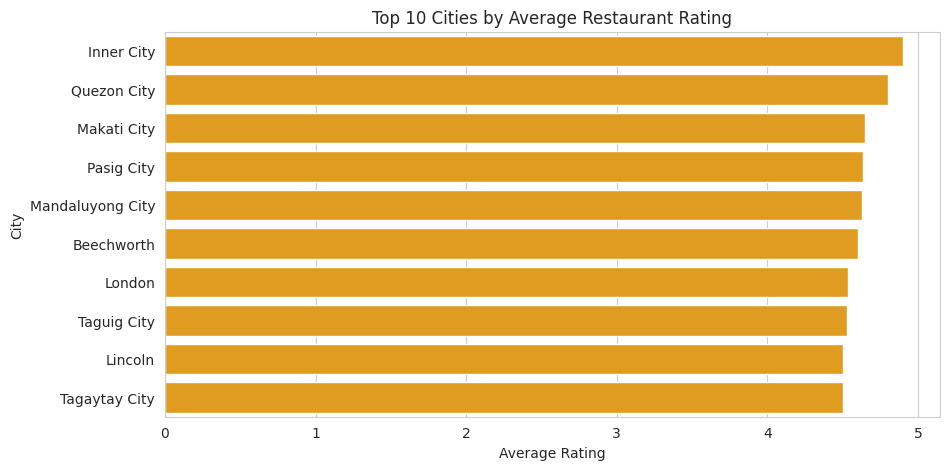

In [69]:
# Average Rating by City
avg_rating_city = df.groupby('City')['Aggregate rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=avg_rating_city.values, y=avg_rating_city.index, color='orange')
plt.title('Top 10 Cities by Average Restaurant Rating')
plt.xlabel('Average Rating')
plt.ylabel('City')
plt.show()

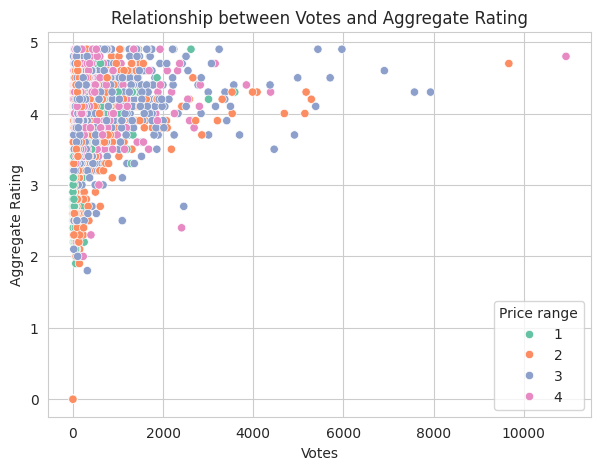

In [59]:
# Relationship between Votes and Ratings
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Votes', y='Aggregate rating', hue='Price range', palette='Set2')
plt.title('Relationship between Votes and Aggregate Rating')
plt.xlabel('Votes')
plt.ylabel('Aggregate Rating')
plt.show()

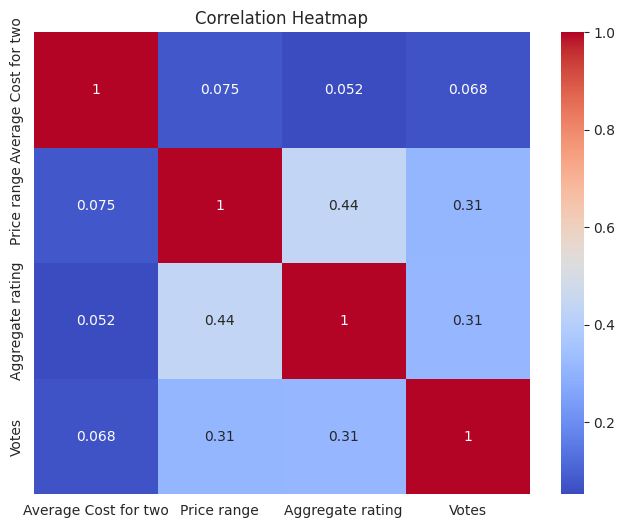

In [62]:
# Heatmap: Correlation among numeric features
plt.figure(figsize=(8,6))
sns.heatmap(df[['Average Cost for two', 'Price range', 'Aggregate rating', 'Votes']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()